In [131]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import pandas as pd
df = pd.read_csv("SFlow_Data_1.csv.csv", names = ["Type", "sflow_agent_address", "inputPort", "outputPort", "src_MAC", "dst_MAC", "ethernet_type", "in_vlan", "out_vlan", "src_IP", "dst_IP", "IP_protocol", "ip_tos", "ip_ttl", "src_port", "dst_port", "tcp_flags", "packet_size", "IP_size", "sampling_rate", "TEST"])


#code for Top 5 Talkers
print("Top 5 Talkers (sender nodes)")
df_src_ip_count = df["src_IP"].value_counts().rename_axis("IP adddress").reset_index(name=" # of packets")
print(df_src_ip_count.head(5))


#code for Top 5 Listeners
print("Top 5 Listeners (receiving nodes)")
df_dst_ip_count = df["dst_IP"].value_counts().rename_axis("IP adddress").reset_index(name=" # of packets")
print(df_dst_ip_count.head(5))

#code for Proportion of TCP and UDP packets
print("Proportion of TCP and UDP packets")
total_count = df["IP_protocol"].count()
df_protocol_packets = df["IP_protocol"].value_counts().rename_axis("Header value").reset_index(name = "# of packets ")
df_tcp = df.loc[df["IP_protocol"] == 6]["IP_protocol"].value_counts().rename_axis("Header value").reset_index(name="# of packets ")
df_udp = df.loc[df["IP_protocol"] == 17]["IP_protocol"].value_counts().rename_axis("Header value").reset_index(name="# of packets ")
df_others = pd.DataFrame({"Header value":["-"], "# of packets ":[total_count]})
df_protocol = pd.concat([df_tcp, df_udp, df_others]).reset_index(drop = True)
df_protocol.insert(1, "Transport layer protocol ", ["TCP", "UDP", "Others"])
protocol_count = df_protocol["# of packets "].values
df_others = pd.DataFrame({"Header value":["-"], "# of packets ":[total_count-protocol_count[0]-protocol_count[1]]})
df_protocol = pd.concat([df_tcp, df_udp, df_others]).reset_index(drop = True)
df_protocol.insert(1, "Transport layer protocol ", ["TCP", "UDP", "Others"])
protocol_count = df_protocol["# of packets "].values
tcp_proportion = protocol_count[0] / total_count * 100
udp_proportion = protocol_count[1] / total_count * 100
others_proportion = (total_count - protocol_count[0] - protocol_count[1]) / total_count * 100
df_protocol.insert(len(df_protocol), "Proportion (%)", [tcp_proportion, udp_proportion, others_proportion])
print(df_protocol.head())


#code for Top 5 applications
print("Top 5 applications ")
df_application_count = df["dst_port"].value_counts().rename_axis("Destination IP port number").reset_index(name="# of packets")
print(df_application_count.head(5))


#code for traffic
df_total_traffic = df["IP_size"].sum()/1000000
print("Total calcaulted sampled traffic (MB): ", df_total_traffic)
df_sampling_rate= 1/2048
print("Estimated Total Traffic taking into account the sampling rate (MB):", df_total_traffic / df_sampling_rate * 15)


#code for Top 5 communication pair
print("Top 5 communication pair")
pairs = df
pairs['pair(src_address,dst_address)'] = None
for i, row in pairs.iterrows():
    ip_pair = []
    ip_pair.append(row['src_IP'])
    ip_pair.append(row['dst_IP'])
    ip_pair.sort()
    pair_tuple = tuple(ip_pair)
    pairs.at[i, 'pair(src_address,dst_address)'] = pair_tuple
data = pairs.groupby("pair(src_address,dst_address)").size().reset_index(name="# of Packets")
grouped_pairs = data.sort_values(["# of Packets"], ascending=False)
print(grouped_pairs.head(5))


Top 5 Talkers (sender nodes)
     IP adddress   # of packets
0   193.62.192.8           3041
1  155.69.160.32           2975
2  130.14.250.11           2604
3  14.139.196.58           2452
4  140.112.8.139           2056
Top 5 Listeners (receiving nodes)
       IP adddress   # of packets
0   103.37.198.100           3841
1   137.132.228.15           3715
2   202.21.159.244           2446
3  192.101.107.153           2368
4     103.21.126.2           2056
Proportion of TCP and UDP packets
  Header value Transport layer protocol   # of packets   Proportion (%)
0            6                       TCP          56064       80.818798
1           17                       UDP           9462       13.639902
2            -                    Others           3844        5.541300
Top 5 applications 
   Destination IP port number  # of packets
0                         443         13423
1                          80          2647
2                       52866          2068
3                      

Top 5 communication pairs:
[('137.132.228.15/193.62.192.8', 4951), ('130.14.250.11/103.37.198.100', 2842), ('14.139.196.58/192.101.107.153', 2368), ('140.112.8.139/103.21.126.2', 2056), ('140.90.101.61/167.205.52.8', 1752)]

Network visualised:



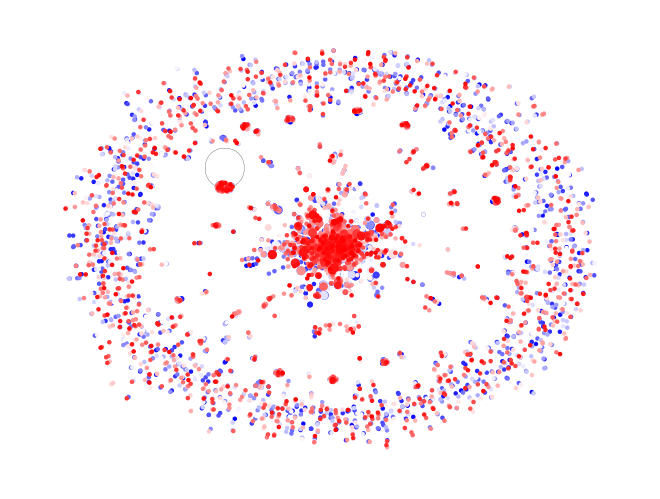

In [132]:
ip_pairs={}
for index, row in df.iterrows():
    pair = row['src_IP']+'/'+row['dst_IP']
    pair2=row['dst_IP']+'/'+row['src_IP']
    if pair in ip_pairs.keys():
        ip_pairs[pair]+=1
    elif pair2 in ip_pairs.keys():
        ip_pairs[pair2]+=1
    else:
        ip_pairs[pair]=1
ip_pairs_grouped = sorted([(k,v) for k,v in ip_pairs.items()], key= lambda x: x[1], reverse=True)
print('Top 5 communication pairs:\n{}\n'.format(ip_pairs_grouped[:5]))

G = nx.Graph()
nodes = list(set(df['src_IP'].tolist()+df['dst_IP'].tolist())) #creating nodes
G.add_nodes_from(nodes)
for (p,n) in ip_pairs_grouped:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)
size = []
for node in nodes:
    if G.degree(node, weight='weight')<25:
        #color.append('g')
        size.append(5)
    elif G.degree(node, weight='weight')<50:
        #color.append('b')
        size.append(10)
    elif G.degree(node, weight='weight')<75:
        #color.append('c')
        size.append(15)
    elif G.degree(node, weight='weight')<100:
        #color.append('y')
        size.append(20)
    elif G.degree(node, weight='weight')<125:
        #color.append('m')
        size.append(25)
    else:
        #color.append('r')
        size.append(30)
edges = G.edges()
weights = [G[u][v]['weight']/500 for u,v in edges]
print('Network visualised:\n')
nx.draw_spring(G, node_size=size, node_color=range(len(nodes)), width=weights, cmap=plt.cm.bwr)

Network visualised:



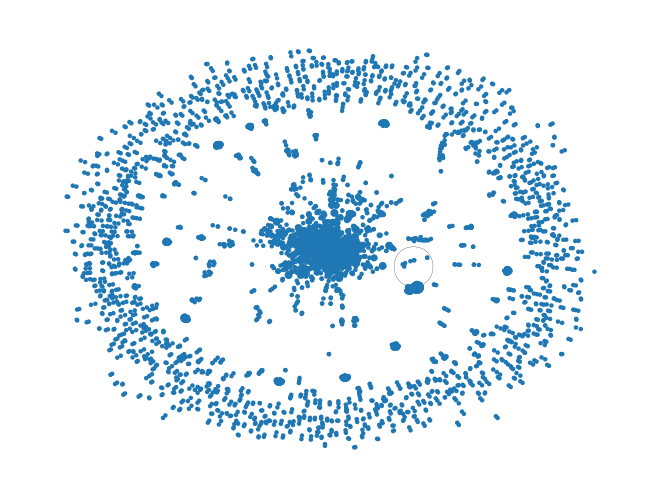

In [121]:
G = nx.Graph()
nodes = list(set(df['src_IP'].tolist()+df['dst_IP'].tolist()))
G.add_nodes_from(nodes)
for (p,n) in ip_pairs_grouped:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)
size = []
for node in nodes:
    if G.degree(node, weight='weight')<50:
        size.append(5)
    elif G.degree(node, weight='weight')<100:
        size.append(10)
    elif G.degree(node, weight='weight')<150:
        size.append(15)
    else:
        size.append(20)
edges = G.edges()
weights = [G[u][v]['weight']/500 for u,v in edges]
nx.draw_spring(G, node_size=size, node_color="tab:blue", width=weights, cmap=plt.cm.bwr)

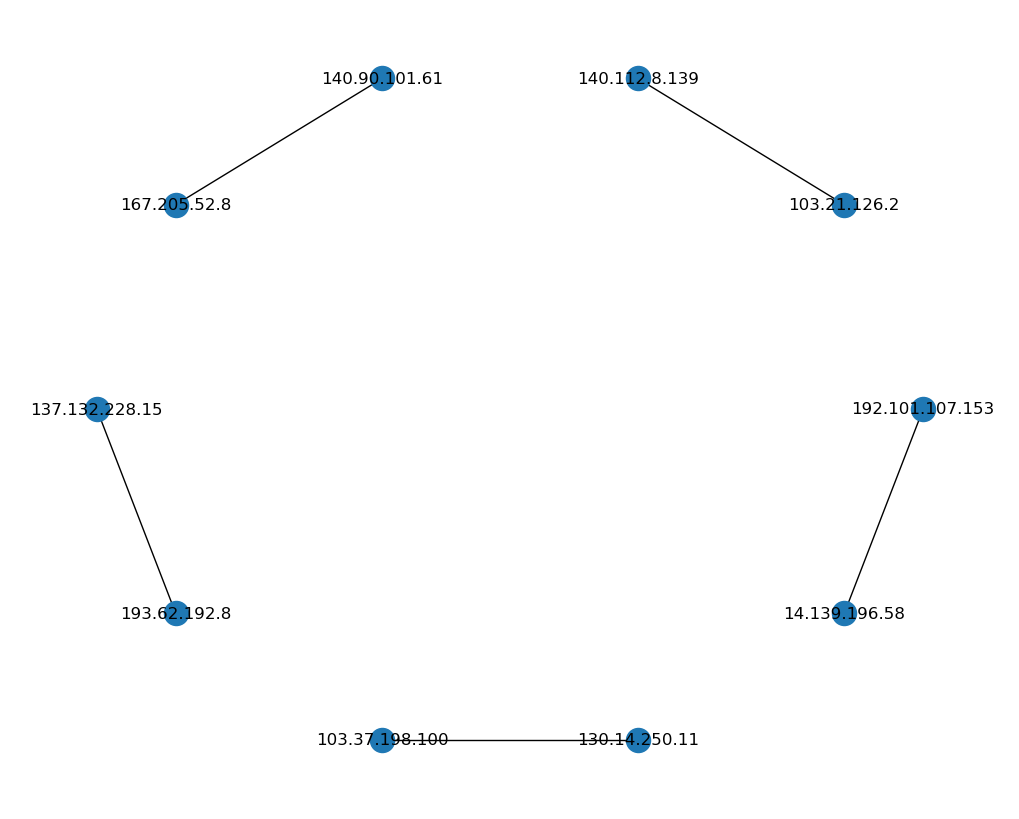

In [144]:
import networkx as nx
data1 = pd.read_csv('top5communicationpair.csv', index_col=False,names=['ip_1','ip_2'])
network = data1[['ip_1','ip_1']]
G = nx.Graph()
G = nx.from_pandas_edgelist(data1, source='ip_1', target='ip_2')
plt.figure(figsize=(10, 8))
nx.draw_shell(G, with_labels=True)

In [ ]:
import networkx as nx
df2=df
df3=df2.value_counts()
print(df3)
G=nx.from_pandas_edgelist(df,source='src_IP',target='dst_IP')
nx.draw_shell(G, with_labels=True)

In [97]:
import seaborn as sb
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
from igraph import Graph, plot

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

df= pd.read_csv('SFlow_Data_1.csv.csv', index_col=False,names=['type','flow_agent_addr','inputPort','outputPort','src_MAC','dst_MAC','eth_type','in_vlan','out_vlan','src_IP','dst_IP','IP_Protocol','ip_tos','ip_ttl','src_port','dst_port','tcp_flags','packet_size','IP_size','sampling_rate', "TEST"])

print('Parsing data...\n')

top5_talkers_ip = df['src_IP'].value_counts()[:5]
top5_listeners_ip = df['dst_IP'].value_counts()[:5]

tcp_count = df['IP_Protocol'].value_counts().get(6)
udp_count = df['IP_Protocol'].value_counts().get(17)
top3_IP_Protocols = df['IP_Protocol'].value_counts()[:3]

top5_apps_protocol = df['dst_port'].value_counts()[:5]

total_traffic = df['IP_size'].sum()

print('Top 5 Talkers (IP):')
print(top5_talkers_ip)
print('\n')
   
print('Top 5 Listeners (IP):')
print(top5_listeners_ip)
print('\n')

print('Top 3 IP Protocols:')
print(top3_IP_Protocols)
print('\n')

print('Top 5 Application Protocols:')
print(top5_apps_protocol)
print('\n')

print('Total traffic: {} bytes\n'.format(total_traffic))

print('Additional stats:\n')

pairs={}
for index, row in df.iterrows():
    word1 = row['src_IP']+'/'+row['dst_IP']
    word2 = row['dst_IP']+'/'+row['src_IP']
    if word1 in pairs.keys():
        pairs[word1]+=1
    elif word2 in pairs.keys():
        pairs[word2]+=1
    else:
        pairs[word1]=1

pairs_sorted = sorted([(k,v) for k,v in pairs.items()], key= lambda x: x[1], reverse=True)

print('Top 5 communication pairs:\n{}\n'.format(pairs_sorted[:5]))

G = nx.Graph()
nodes = list(set(df['src_IP'].tolist()+df['dst_IP'].tolist())) #creating nodes
G.add_nodes_from(nodes)
for (p,n) in pairs_sorted:
    G.add_edge(p.split('/')[0], p.split('/')[1], weight=n)
size = []
for node in nodes:
    if G.degree(node, weight='weight')<25:
        #color.append('g')
        size.append(5)
    elif G.degree(node, weight='weight')<50:
        #color.append('b')
        size.append(10)
    elif G.degree(node, weight='weight')<75:
        #color.append('c')
        size.append(15)
    elif G.degree(node, weight='weight')<100:
        #color.append('y')
        size.append(20)
    elif G.degree(node, weight='weight')<125:
        #color.append('m')
        size.append(25)
    else:
        #color.append('r')
        size.append(30)
edges = G.edges()
weights = [G[u][v]['weight']/500 for u,v in edges]
print('Network visualised:\n')
nx.draw_spring(G, node_size=size, node_color=range(len(nodes)), width=weights, cmap=plt.cm.bwr)
print("finish")

In [ ]:
print("finish")